## Word2Vec

Testing Word2Vec implementation on Movie Reviews dataset provided by NLTK.

> P.S.: This implementation of Word2Vec should't be used, it's only for educational porpuses.

In [1]:
import string
import re
from random import shuffle
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
import spacy
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import sys

sys.path.append("..")
from text.w2v import Word2Vec

%matplotlib inline

np.seterr(all='raise')

nlp = spacy.load("en_core_web_sm")
stpwords = list(sorted(list(set(stopwords.words('english') + list(string.punctuation))))) # + list(nlp.Defaults.stop_words)

# Download if you don't have already!
# nltk.download('movie_reviews')

In [2]:
def execute_spacy(word):
    try:
        return [w.lemma_ for w in nlp(re.sub(r'[-+=:_$@!#\/\\]', "", word), disable=["parser"]) if len(w) > 0][0]
    except:
        return ""

def is_number(word):
    try:
        complex(word) # for int, long, float and complex
    except ValueError:
        return False
    return True


# Review categories
print(movie_reviews.categories()) # Output: [u'neg', u'pos']
 
# Total positive reviews
print(len(movie_reviews.fileids('pos'))) # Output: 1000
 
# Total negative reviews
print(len(movie_reviews.fileids('neg'))) # Output: 1000

movie_reviews_docs = []
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category)[:10]:
        #documents.append((list(movie_reviews.words(fileid)), category))
        phrases = " ".join(movie_reviews.words(fileid)).split(".")
        movie_reviews_docs.append((phrases, category))

print("===> Starting...")
documents = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    for phrases, category in movie_reviews_docs:
        for phrase in phrases:
            words = phrase.split()
            words = [word for word in words if word not in stpwords and not is_number(word) and len(word) > 2]
            if len(words) > 0:
                fwords = [word for word in exc.map(execute_spacy, words, chunksize=5) if len(word) > 0]
                documents.append((fwords, category))
shuffle(documents)
print("===> Finished...")

['neg', 'pos']
1000
1000
===> Starting...
===> Finished...


In [4]:
print(f"Qtd. Documents: {len(documents)}")
print(f"Qtd. Words: {np.sum([len(document[0]) for document in documents])}")
print("-" * 20)
print("Examples: ")
for document in documents[:10]:
    print(document[1], ":", document[0][:5])

Qtd. Documents: 536
Qtd. Words: 6654
--------------------
Examples: 
neg : ['since', 'eye', 'flutter', 'nervous', 'smile']
neg : ['stretch', 'dude']
pos : ['coalition', 'create', 'soon', 'start', 'fall']
pos : ['male', 'bumble', 'adult', 'rushmore', 'bill']
pos : ['tracy', 'flick', 'reese', 'witherspoon', 'achiever']
pos : ['think', 'anyone', 'needs', 'briefed', 'jack']
pos : ['every', 'one', 'spielberg', 'subjective', 'underwater']
neg : ['deep', 'welle', 'digs', 'investigation', 'obsess']
neg : ['capsule', 'planet', 'mars', 'police', 'take']
pos : ['join', 'three', 'woman', 'little', 'except']


In [12]:
corpus = [document[0] for document in documents[:120]]

w2v = Word2Vec(learning_rate=1e-1, window=5, latent_space=100)
X, y = w2v.generate_bow(corpus)
print("Starting training...")
loss = w2v.train(X, y, epochs=100, show_iter_err=25)

Starting training...
Epoch 26/100, Time: 82.83 ====> Loss: [51.80231]
Epoch 51/100, Time: 79.387 ====> Loss: [50.43007]
Epoch 76/100, Time: 74.8 ====> Loss: [50.35785]
Epoch 100/100 ====> Loss: [50.34606]


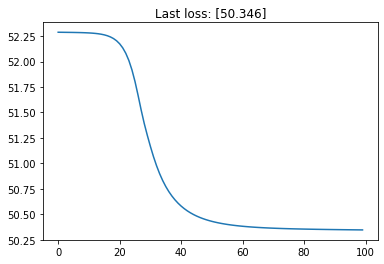

In [13]:
plt.title(f"Last loss: {np.round(loss[-1], 3)}")
plt.plot(loss)
plt.show()

In [14]:
wv = w2v.wv
word_index = w2v.word_index
index_word = w2v.index_word

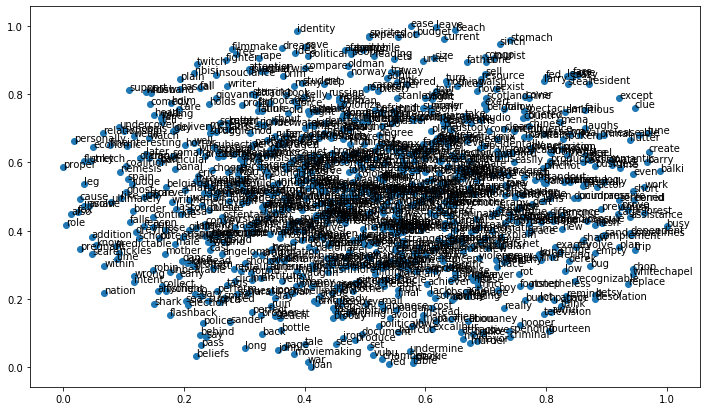

In [15]:
X_embedded = TSNE(
    n_components=2,
    perplexity=50,
    metric="cosine",
    n_jobs=-1,
    random_state=42
).fit_transform(wv)
X_embedded = MinMaxScaler().fit_transform(X_embedded)

plt.figure(figsize=(12, 7))
ax = plt.subplot(1, 1, 1) #, projection='3d')
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', color='C0')
for i, txt in enumerate(w2v.word_index):
    plt.annotate(txt, (X_embedded[i, 0], X_embedded[i, 1]))
plt.show()

In [18]:
wd = "film"
print(f"Top 10 closest words to: {wd}")
print("-" * 20)
print("Cosine:")
for word, dist in w2v.find_similar(wd, topn=10):
    print("-", word, dist)
print("Euclidian:")
for word, dist in w2v.find_similar(wd, topn=10, metric="euclidian"):
    print("-", word, dist)

Top 10 closest words to: film
--------------------
Cosine:
- editing [0.9500493779836275]
- obstetrician [0.9478309567190291]
- bland [0.9476381861771922]
- struggle [0.9465222375650532]
- example [0.9450594060767091]
- please [0.944985093270845]
- attractive [0.9445622639694651]
- affair [0.9443855455412125]
- value [0.9438608764736245]
- start [0.9436014244085827]
Euclidian:
- sand [5.965201902765035]
- alien [5.964339172288916]
- within [5.920363805358477]
- scare [5.850620050757872]
- hits [5.782915911394678]
- predictable [5.743494438971883]
- document [5.723367977304942]
- personally [5.714064428098851]
- tune [5.702484169676907]
- mingle [5.689322989449117]
